In [3]:
'''
Exercise 8
'''
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt #define shorthand "plt" for package matlobplit.pyplot
import numpy as np #define shorthand "np" for the numpy package
import scipy.stats as sci
import math as mat
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Markdown as md
import pystan
from psis import psisloo



# Exercise 8
Six factory machines' quality measurements STAN code is presented below for the separate, pooled and hierarchical models:

In [4]:
#Separate STAN model

factory_separate_stan_code="""
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}
parameters {
    vector[K] mu;         // group means
    vector<lower=0>[K] sigma;  // std's of the groups
}
model {
  y ~ normal(mu[x], sigma[x]);
}
generated quantities {
    real ypred6;
    vector[N] log_lik;
    ypred6 = normal_rng(mu[6], sigma[6]);  
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma[x[i]]);    
}

"""

sm_factory_separate = pystan.StanModel(model_code=factory_separate_stan_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1bfc4e9af8e67e9dc3cef8d227a9abeb NOW.


In [6]:
#Pooled STAN model

factory_pooled_stan_code="""
data {
    int<lower=0> N; // number of data points
    vector[N] y; //
}
parameters {
    real mu;               // prior mean
    real<lower=0> sigma;   // prior std
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
    real ypred6;
    vector[N] log_lik;
    ypred6 = normal_rng(mu, sigma);
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu, sigma);   
}
"""


sm_factory_pooled = pystan.StanModel(model_code=factory_pooled_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f30e1cbe8094112c8b53d4af99ea40e NOW.


In [7]:
# Hierarchical STAN model

factory_hierarchical_stan_code="""
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}
parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
}
model {
    mu ~ normal(mu0, sigma0); // population prior with unknown parameters
    y ~ normal(mu[x], sigma);
}
generated quantities {
    real ypred6;
    real mu7;
    vector[N] log_lik;
    ypred6 = normal_rng(mu[6], sigma);
    mu7 = normal_rng(mu0, sigma0);
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);     
}
"""

sm_factory_hierarchical = pystan.StanModel(model_code=factory_hierarchical_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a8be7fc9197f4f28ab0b72237d8679c NOW.


Let's create the data for the models.

In [5]:
y=np.array(([83 ,117, 101, 105, 79, 57],
[92, 109, 93, 119, 97, 92],
[92, 114, 92, 116, 103, 104],
[46, 104, 86, 102, 79, 77],
[67, 87, 67, 116, 92, 100]  ))

y=np.reshape(y, 30, order='F')
x=np.concatenate( (np.ones(5) , 2*np.ones(5) ,  3*np.ones(5),
                   4*np.ones(5),5*np.ones(5),6*np.ones(5)) ).astype(int)

factory_separate_dat = {'y':y,
                            'x': x,
                            'N': 30,
                            'K': 6
                           }

factory_pooled_dat = {'y':y,
                      'N': 30,
                      }
factory_hierarchical_dat = {'y':y,
                           'x': x,
                           'N': 30,
                           'K': 6
                           }

## Separate model 
In the separate model each machine $j$ has its own mean $\mu_j$ and standard deviation $\sigma_j$. This makes total of 12 parameters to be approximated.

The PSIS-LOO value is -132.146, which is the highest of the three models. The smaller the number the better the model is considered to be if the PSIS-LOO value can be considered stable. This model is the worst of the three based on the PSIS-LOO value.

The effective number of parameters $p_{eff}=p_{loo-cv}$ is 9.530012698216112 which means that out of the 12 parameters estimated 9,5 are considered to be effective.

The calculated $\hat{k}$ values of PSIS_LOO values for the observatios with the Separate model are presented in the histogram below. There are 4 of the $\hat{k}$ values that are over > 0.7 so the estimate is probably little bit biased. This is means that the PSIS-LOO value is not completely accurate. There should be used some more accurate and computationally more expensive methods to evaluate LOO value for the 4 observations in question to get a more accurate estimate. However it can be said that the value quite clearly is worse than the other two.



PSIS-LOO value: -132.14664228183975
p_loocv effective number of parameters: 9.530012698216112


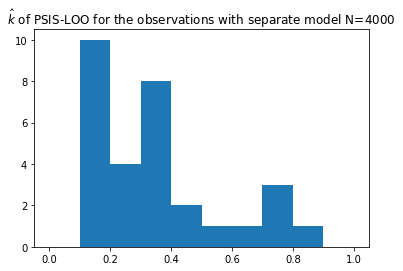

Inference for Stan model: anon_model_1bfc4e9af8e67e9dc3cef8d227a9abeb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        75.83    0.49  16.06  45.01  68.42  76.02  83.34 104.71   1094    1.0
mu[2]       106.14    0.24   9.66  86.91  101.5 106.18 110.77 125.92   1588    1.0
mu[3]        88.13    0.37  11.09  68.14  82.75  87.89  93.14 110.97    907   1.01
mu[4]        111.8    0.18   6.47  98.94  108.7 111.78 114.87 125.08   1311    1.0
mu[5]        90.44    0.27   8.73  73.89  85.85  90.21  94.59 108.57   1067    1.0
mu[6]        86.13    0.46  16.55  55.23   77.9  85.66  93.88 121.25   1289    1.0
sigma[1]     31.11    0.76  24.61  12.83  19.32  25.44  35.26   79.7   1060    1.0
sigma[2]     18.69    0.33  11.98   7.68  11.65  15.28  21.27   50.2   1290    1.0
sigma[3]     20.71    0.53  14.38   8.37  12.65  16.58  23.54  5

In [63]:
#Separate

fit_separate = sm_factory_separate.sampling(data=factory_separate_dat, n_jobs=-1)
ypred6_separate=fit_separate.extract(permuted=True)['ypred6']
mu_separate=fit_separate.extract(permuted=True)['mu']
log_lik=fit_separate.extract(permuted=True)['log_lik']
psis=psisloo(log_lik)
print("PSIS-LOO value:", psis[0])
#Estimate of the effective number of parameters
#lppd (computd log pointwise predictive density) calculation
S=np.size(log_lik,0)
lppd=sum(np.log([1/S*sum(np.exp(col)) for col in log_lik.T]))
#Formula: p_loocv=lppd-lppd_loocv
p_loocv=lppd-psis[0]
print("p_loocv effective number of parameters:",p_loocv)
plt.hist(psis[2], bins=np.linspace(0,1,11))
plt.title("$\^{k}$ of PSIS-LOO for the observations with separate model N=4000")
plt.show()

summary_separate=fit_separate.summary()
summary_df_separate=pd.DataFrame(summary_separate['summary'], 
                                 columns=summary_separate['summary_colnames'], 
                                 index=summary_separate['summary_rownames'])

#Print info on the fitting and sampling of paramters alpha and beta 
print(fit_separate)
#fit_separate.plot()
#plt.show()

#plt.hist(mu_separate[:,5],bins=50)
#plt.title("Posterior mean of machine 6")
#plt.show()
#plt.hist(ypred6_separate, bins=50)
#plt.title("Predictive distribution of quality measurement for machine 6")
#plt.show()

## Pooled model 
In the pooled model all the data of the machines are assumed to be from one machine in theoretically speaking. All the machines have thus same mean $\mu$ and standard deviation $\sigma$. This way there are only two parameters in the model to estimate.

The PSIS-LOO value is -130.99, which is the middle value for the three models. The smaller the number the better the model is considered to be if the PSIS-LOO value can be considered stable. This is between the separate and the hierarchical models in goodness-of-fit.

The effective number of parameters $p_{eff}=p_{loo-cv}$ is 2.02 which means that the 2 parameters are considered quite effective for the model.

The calculated $\hat{k}$ values of PSIS_LOO values for the observatios with the Pooled model are presented in the histogram below. All the $\hat{k}$ values are under < 0.7, so the PSIS-LOO estimate can be considered to be good approximation.


PSIS-LOO value: -130.99238195225863
p_loocv effective number of parameters: 2.015749266322473


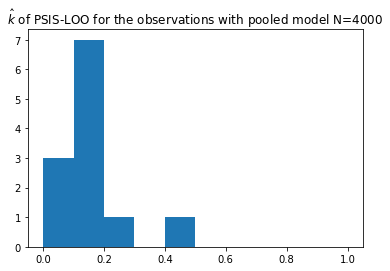

Inference for Stan model: anon_model_3f30e1cbe8094112c8b53d4af99ea40e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu           92.93    0.06   3.42  86.21  90.67  92.89  95.15   99.9   2769    1.0
sigma        18.86    0.05   2.65  14.47  16.97  18.56  20.44  24.84   2504    1.0
ypred6       92.52    0.31   19.4  53.47  79.58  92.91 105.25  131.1   4040    1.0
log_lik[1]   -4.01  2.9e-3   0.14  -4.32   -4.1   -4.0  -3.91  -3.74   2532    1.0
log_lik[2]   -3.86  2.8e-3   0.14  -4.16  -3.95  -3.86  -3.77  -3.61   2411    1.0
log_lik[3]   -3.86  2.8e-3   0.14  -4.16  -3.95  -3.86  -3.77  -3.61   2411    1.0
log_lik[4]   -7.13    0.02   0.87  -9.12  -7.66  -7.03   -6.5  -5.72   2976    1.0
log_lik[5]   -4.86  5.1e-3   0.29  -5.54  -5.02  -4.82  -4.65  -4.39   3143    1.0
log_lik[6]   -4.73  4.8e-3   0.26  -5.32  -4.88   -4.7  -4.54  -

In [65]:
# Pooled

fit_pooled = sm_factory_pooled.sampling(data=factory_pooled_dat, n_jobs=-1)
#mu7_pooled=fit_pooled.extract(permuted=True)['y7']
ypred6_pooled=fit_pooled.extract(permuted=True)['ypred6']
mu_pooled=fit_pooled.extract(permuted=True)['mu']
mu7_pooled=mu_pooled
log_lik=fit_pooled.extract(permuted=True)['log_lik']
psis=psisloo(log_lik)
print("PSIS-LOO value:", psis[0])
#Estimate of the effective number of parameters
#lppd (computd log pointwise predictive density) calculation
S=np.size(log_lik,0)
lppd=sum(np.log([1/S*sum(np.exp(col)) for col in log_lik.T]))
#Formula: p_loocv=lppd-lppd_loocv
p_loocv=lppd-psis[0]
print("p_loocv effective number of parameters:",p_loocv)
plt.hist(psis[2],bins=np.linspace(0,1,11))
plt.title("$\^{k}$ of PSIS-LOO for the observations with pooled model N=4000")
plt.show()

summary_pooled=fit_pooled.summary()
summary_df_pooled=pd.DataFrame(summary_pooled['summary'], 
                               columns=summary_pooled['summary_colnames'], 
                               index=summary_pooled['summary_rownames'])
#Print info on the fitting and sampling of paramters alpha and beta 
print(fit_pooled)
#fit_pooled.plot()
#plt.show()

#plt.hist(mu_pooled,bins=50)
#plt.title("Posterior mean of machine 6")
#plt.show()
#plt.hist(ypred6_pooled, bins=50)
#plt.title("Predictive distribution of quality measurement for machine 6")
#plt.show()
#plt.hist(mu7_pooled, bins=50)
#plt.title("Posterior distribution of mean of quality measurement for machine 7\n Posterior mean is the same for all the machines for Pooled model")
#plt.show()


## Hierarchical model 
In the hierarchical model $\mu_0$ and $\sigma_0$ were set as parameters for the prior distrubution mu $\mu \sim N( \mu_0 , \sigma_0 )$ for all machines where prior distribution for $\mu_0$ and $\sigma_0$ is assumed to be uniform. The standard deviation of quality measurements of all the machines was assumed to be equal for all machines. In total there are 9 parameters to be estimated.

The PSIS-LOO value is -126.83, which is the smallest value for the three models. The smaller the number the better the model is considered to be if the PSIS-LOO value can be considered stable. So this model can be considered to be **the best** of the three.

The effective number of parameters $p_{eff}=p_{loo-cv}$ is 5.73 which means that out of the 9 parameters 5.73 are considered quite effective for the model.

The calculated $\hat{k}$ values of PSIS_LOO values for the observatios with the Pooled model are presented in the histogram below. All the $\hat{k}$ values are under < 0.7, so the PSIS-LOO estimate can be considered to be good.


PSIS-LOO value: -126.83042187252312
p_loo-cv estimated effective number of parameters: 5.726957568402469


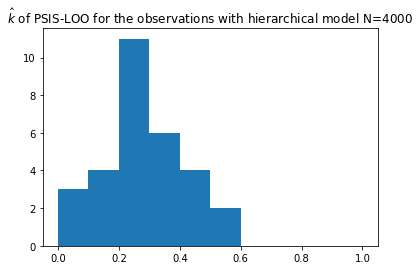

Inference for Stan model: anon_model_2a8be7fc9197f4f28ab0b72237d8679c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0          92.83    0.19   8.14  76.38  88.37  92.85  97.17 109.41   1756    1.0
sigma0       16.52    0.28  10.45    4.8  10.28  14.16  19.62  43.12   1350    1.0
mu[1]        79.76    0.16   6.84  66.23  75.42  79.75  84.26  93.38   1935    1.0
mu[2]       103.01    0.13   6.65  89.53  98.55 103.11 107.44 115.78   2512    1.0
mu[3]        88.79    0.11   6.07  76.46   84.7  88.96  92.75 100.55   3167    1.0
mu[4]       107.44    0.15   6.78  93.72 102.95 107.58 111.95 120.46   1916   1.01
mu[5]        90.81     0.1   6.12  78.72  86.75  90.92  94.89 102.66   3463    1.0
mu[6]        87.37    0.11   6.27  74.75  83.26  87.57  91.53  99.47   3371    1.0
sigma        15.23    0.05   2.38  11.29  13.57  15.03  16.67  2

In [66]:
# Hierarchical

fit_hierarchical = sm_factory_hierarchical.sampling(data=factory_hierarchical_dat, n_jobs=-1)
mu7_hierarchical=fit_hierarchical.extract(permuted=True)['mu7']
ypred6_hierarchical=fit_hierarchical.extract(permuted=True)['ypred6']
mu_hierarchical=fit_hierarchical.extract(permuted=True)['mu']
log_lik=fit_hierarchical.extract(permuted=True)['log_lik']
psis=psisloo(log_lik)
print("PSIS-LOO value:", psis[0])
#Estimate of the effective number of parameters
#lppd (computd log pointwise predictive density) calculation
S=np.size(log_lik,0)
lppd=sum(np.log([1/S*sum(np.exp(col)) for col in log_lik.T]))
#Effective number of parameters formula: p_loocv=lppd-lppd_loocv
p_loocv=lppd-psis[0]
print("p_loo-cv estimated effective number of parameters:",p_loocv)
plt.hist(psis[2],bins=np.linspace(0,1,11))
plt.title("$\^{k}$ of PSIS-LOO for the observations with hierarchical model N=4000")
plt.show()

summary_hierarchical=fit_hierarchical.summary()
summary_df_hierarchical=pd.DataFrame(summary_hierarchical['summary'], 
                                     columns=summary_hierarchical['summary_colnames'], 
                                     index=summary_hierarchical['summary_rownames'])

#Print info on the fitting and sampling of paramters alpha and beta 
print(fit_hierarchical)
#fit_hierarchical.plot()
#plt.show()

#plt.hist(mu_hierarchical[:,5],bins=50)
#plt.title("Posterior mean of machine 6")
#plt.show()
#plt.hist(ypred6_hierarchical, bins=50)
#plt.title("Predictive distribution of quality measurement for machine 6")
#plt.show()
#plt.hist(mu7_hierarchical, bins=50)
#plt.title("Posterior distribution of mean of quality measurement for machine 7")
#plt.show()
